In [45]:
import sys
import pandas as pd
import matplotlib.pyplot as plt

df_500030 = pd.read_csv('./../data/500030_2024-07-01_2024-09-30.csv')
df_500030['patient_id'] = 500030
df_500030['date_original'] = df_500030['date']

df_679372 = pd.read_csv('./../data/679372_2024-07-01_2024-09-30.csv')
df_679372['patient_id'] = 679372
df_679372['date_original'] = df_679372['date']

df = pd.concat([df_500030, df_679372])
df['interval'] = df['date'].apply(lambda x: x[27:29]) # trimming the head
df['date'] = df['date'].apply(lambda x: x[:19]) # trimming the tail
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')

C:\Users\paulp\AppData\Local\Temp\ipykernel_10692\481733811.py:9: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_679372 = pd.read_csv('./../data/679372_2024-07-01_2024-09-30.csv')


Start code Here

# Objective

Create Difference Plot for BGL users

In [47]:
df_500030 = df[df['patient_id']==500030]
df_679372 = df[df['patient_id']==679372]

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

def junwon_p(df, n_days=3, agg_interval=None):
    """
    Processes change in BGL over second (slope/differenced) and plots trends for randomly selected consecutive days.
    Also plots the original plot to see/compare changes in slopes and actual data.

    Parameters:
    df (pd.DataFrame): Cleaned data frame for one user.
    n_days (int): Number of consecutive days to plot (default: 3).
    agg_interval (str or None): Resampling interval ('15T' for 15 minutes, '1H' for 1 hour, None to show original data).
    
    Returns:
    pd.DataFrame: Processed DataFrame with added blood glucose change rates.
    """
    # Ensure DataFrame is sorted by 'date'
    df = df.sort_values(by='date')

    # Drop duplicate entries by 'date', keeping the first
    df = df.drop_duplicates(subset='date', keep='first')

    # Calculate the difference in blood glucose levels between consecutive rows
    df['bgl_diff'] = df['bgl'].diff()

    # Calculate time difference between consecutive entries in seconds
    df['time_diff'] = df['date'].diff().dt.total_seconds()

    # Calculate rate of blood glucose change per second
    df['bgl_change_per_second'] = df['bgl_diff'] / df['time_diff']

    # Extract unique dates
    unique_dates = df['date'].dt.date.unique()

    # Randomly select a starting point for consecutive days
    start_idx = np.random.randint(0, len(unique_dates) - n_days)
    selected_dates = unique_dates[start_idx:start_idx + n_days]

    # Filter the DataFrame for the selected dates and set 'date' as the index
    df_filtered = df[df['date'].dt.date.isin(selected_dates)].set_index('date')

    # Resample the filtered data if an aggregation interval is provided
    if agg_interval is not None:
        df_filtered = df_filtered.resample(agg_interval).mean(numeric_only=True)

    # Create two subplots: one for 'bgl' and one for 'bgl_change_per_second'
    fig, axes = plt.subplots(2, 1, figsize=(10, 10))

    # Plot the 'bgl' values (original or resampled)
    sns.lineplot(ax=axes[0], x=df_filtered.index, y=df_filtered['bgl'], marker='o')
    axes[0].set_title(f'Random BGL Trends Over {n_days} Days', pad=20, fontsize=14)
    axes[0].set_xlabel('Time (HH:MM)', fontsize=12)
    axes[0].set_ylabel('BGL', fontsize=12)

    # Mark the start of each new day with vertical lines for 'bgl'
    for day in selected_dates[1:]:
        day_start = df_filtered[df_filtered.index.date == day].index.min()
        axes[0].axvline(day_start, color='gray', linestyle='--')
        axes[0].text(day_start, axes[0].get_ylim()[1], str(day), ha='center', va='bottom')

    # Set x-axis ticks at 2-hour intervals for better readability (for 'bgl' plot)
    axes[0].xaxis.set_major_locator(mdates.HourLocator(interval=2))
    axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    axes[0].tick_params(axis='x', rotation=90)

    # Plot 'bgl_change_per_second'
    sns.lineplot(ax=axes[1], x=df_filtered.index, y=df_filtered['bgl_change_per_second'], marker='o')
    axes[1].set_title(f'Random BGL Change per Second Trends Over {n_days} Days', pad=20, fontsize=14)
    axes[1].set_xlabel('Time (HH:MM)', fontsize=12)
    axes[1].set_ylabel('BGL Change per Second', fontsize=12)

    # Mark the start of each new day with vertical lines for 'bgl_change_per_second'
    for day in selected_dates[1:]:
        day_start = df_filtered[df_filtered.index.date == day].index.min()
        axes[1].axvline(day_start, color='gray', linestyle='--')
        axes[1].text(day_start, axes[1].get_ylim()[1], str(day), ha='center', va='bottom')

    # Set x-axis ticks at 2-hour intervals for better readability (for 'bgl_change_per_second' plot)
    axes[1].xaxis.set_major_locator(mdates.HourLocator(interval=2))
    axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    axes[1].tick_params(axis='x', rotation=90)

    # Adjust layout to prevent clipping
    plt.tight_layout()
    plt.show()

    #return df_filtered  # Return the final DataFrame
    return None


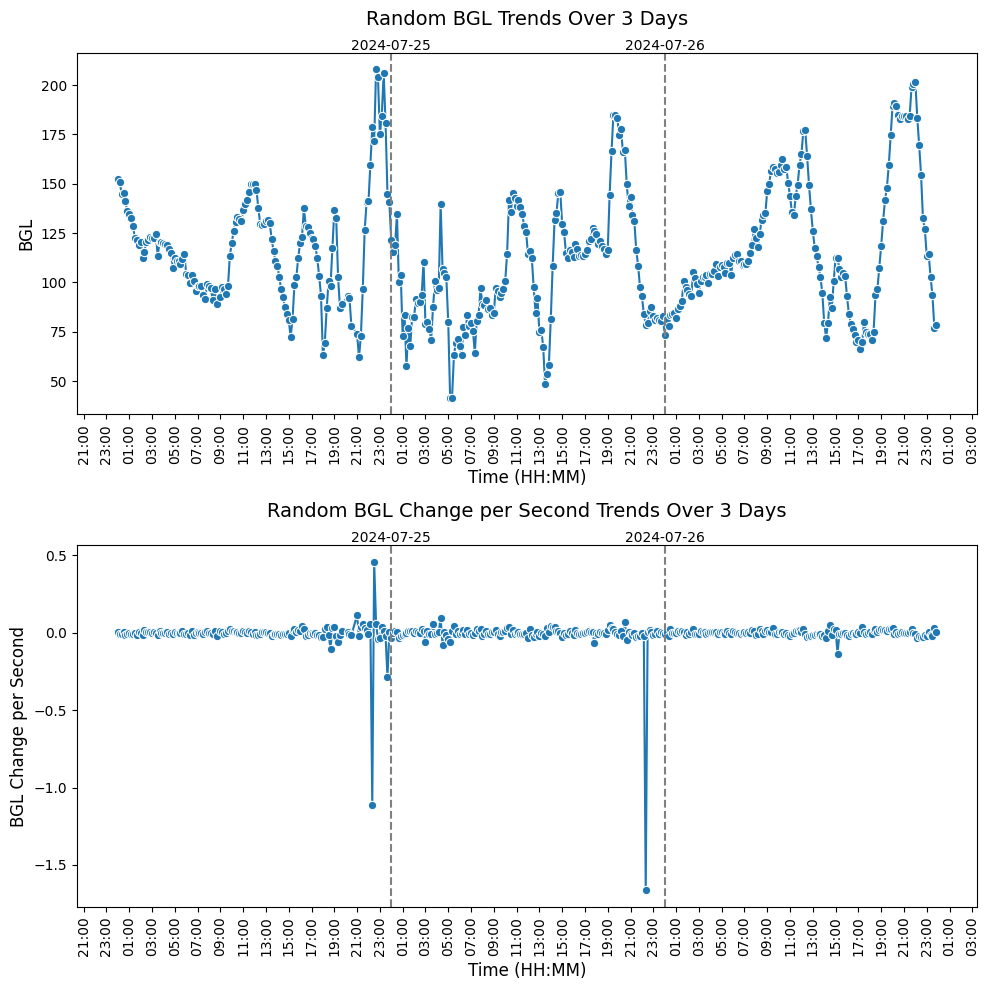

In [81]:
junwon_p(df_500030,agg_interval='10T')

# attempt with p-chart for confidence levels

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def junwon_p_with_p_chart(df, n_days=3, agg_interval='15T', threshold=3):
    """
    Processes blood glucose data, detects anomalies using a p-chart, and plots trends for randomly selected consecutive days.

    Parameters:
    df (pd.DataFrame): DataFrame with 'date' column (datetime) and 'bgl' (blood glucose level).
    n_days (int): Number of consecutive days to plot (default: 3).
    agg_interval (str): Resampling interval (default: '15T' for 15 minutes).
    threshold (float): The threshold for anomaly detection (default: 3).
    
    Returns:
    pd.DataFrame: Processed DataFrame with added blood glucose change rates and anomaly detection.
    """
    # Ensure DataFrame is sorted by 'date'
    df = df.sort_values(by='date')

    # Drop duplicate entries by 'date', keeping the first
    df = df.drop_duplicates(subset='date', keep='first')

    # Calculate the difference in blood glucose levels between consecutive rows
    df['bgl_diff'] = df['bgl'].diff()

    # Calculate time difference between consecutive entries in seconds
    df['time_diff'] = df['date'].diff().dt.total_seconds()

    # Calculate rate of blood glucose change per second
    df['bgl_change_per_second'] = df['bgl_diff'] / df['time_diff']

    # Extract unique dates
    unique_dates = df['date'].dt.date.unique()

    # Randomly select a starting point for consecutive days
    start_idx = np.random.randint(0, len(unique_dates) - n_days)
    selected_dates = unique_dates[start_idx:start_idx + n_days]

    # Filter the DataFrame for the selected dates and set 'date' as the index
    df_filtered = df[df['date'].dt.date.isin(selected_dates)].set_index('date')

    # Resample the filtered data by the specified interval, considering only numeric columns
    df_resampled = df_filtered.resample(agg_interval).mean(numeric_only=True)

    # Detect anomalies based on the threshold (if the rate of change exceeds the threshold, mark it as an anomaly)
    df_resampled['anomaly'] = np.where(np.abs(df_resampled['bgl_change_per_second']) > threshold, 1, 0)

    # Proportion of anomalies at each time interval
    df_resampled['anomaly_proportion'] = df_resampled['anomaly'].expanding().mean()

    # Calculate control limits for the p-chart
    p_bar = df_resampled['anomaly'].mean()  # Average proportion of anomalies
    n = len(df_resampled)  # Number of samples
    sigma = np.sqrt((p_bar * (1 - p_bar)) / n)  # Standard deviation for control limits

    UCL = p_bar + 3 * sigma  # Upper Control Limit
    LCL = max(0, p_bar - 3 * sigma)  # Lower Control Limit (cannot be negative)

    # Plot the data
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=df_resampled.index, y=df_resampled['bgl_change_per_second'], marker='o', label="BGL Change per Second")

    # Mark the start of each new day with vertical lines
    for day in selected_dates[1:]:
        day_start = df_resampled[df_resampled.index.date == day].index.min()
        plt.axvline(day_start, color='gray', linestyle='--')
        plt.text(day_start, plt.ylim()[1], str(day), ha='center', va='bottom')

    # Set x-axis ticks at 2-hour intervals for better readability
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))  # Set ticks every 2 hours
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Only show the time

    # Rotate the labels vertically and improve spacing
    plt.xticks(rotation=90)

    # Plot p-chart (proportion of anomalies over time)
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=df_resampled.index, y=df_resampled['anomaly_proportion'], label="Proportion of Anomalies")
    plt.axhline(UCL, color='red', linestyle='--', label=f'UCL ({UCL:.2f})')
    plt.axhline(LCL, color='green', linestyle='--', label=f'LCL ({LCL:.2f})')
    
    # Set plot labels and title with padding to avoid overlap
    plt.xlabel('Time (HH:MM)', fontsize=12)
    plt.ylabel('Proportion of Anomalies', fontsize=12)
    plt.title('P-Chart for Anomaly Detection', pad=20, fontsize=14)

    # Adjust layout to prevent clipping
    plt.tight_layout()
    plt.legend()
    plt.show()

    return


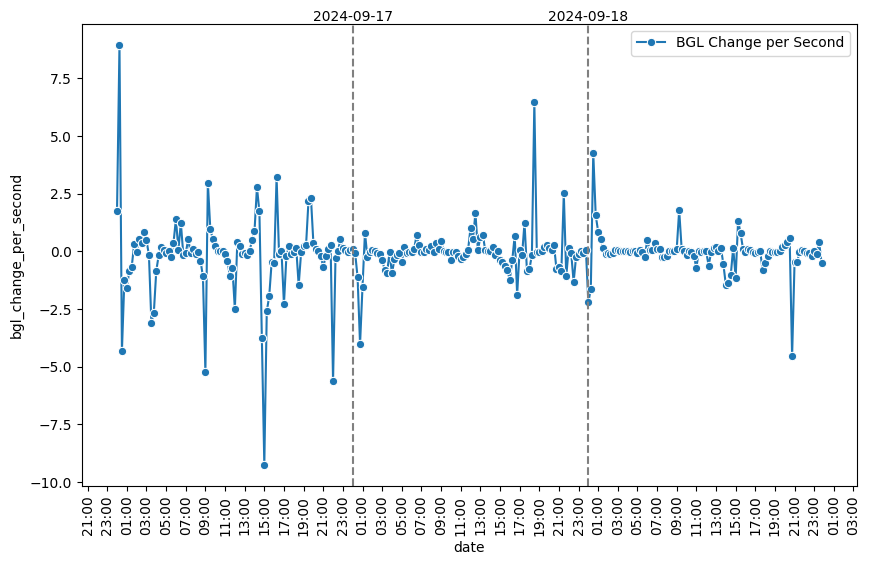

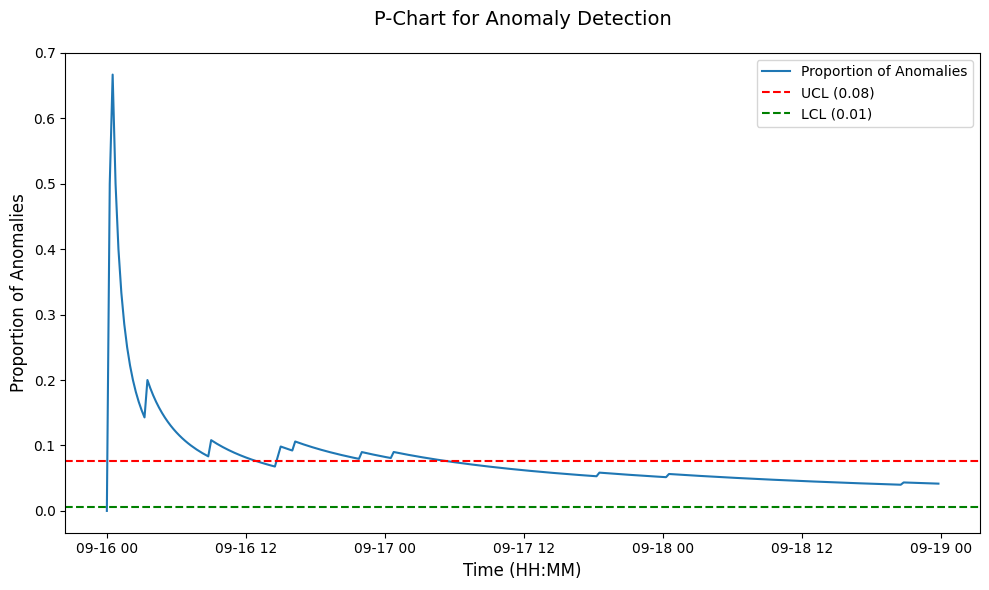

In [51]:
junwon_p_with_p_chart(df, n_days=3, agg_interval='15T', threshold=3)
